<a href="https://colab.research.google.com/github/falahamro/Topic-Modeling-/blob/main/DVE_Cluster_Topical_Analysis_topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In previous studies, we conducted [clustering analysis](https://https://github.com/falahamro/Identity_mapping/blob/main/Final_Holistic_Identity_Mapping_domestic.ipynb). 


To better understand the semantic meaning of the obtained clusters, topic modeling based on Latent Dirichlet Allocation (LDA) was applied to the entire dataset. Topic modeling can discover hidden themes from text based on the semantic associations between words and provide abstract topics. These abstract topics can be used to construct meaning for our cluster classes and discover latent but distinctive behavioral patterns of DVEs from their discourse. First, we discuss the dominant topics for the entire dataset. This will serve as a baseline for subsequent comparison of how users in each of our cluster classes discuss these topics and determine whether there were any indications of divergent terms from the three clusters.

## Installs and Imports

In [2]:
import base64
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 0)
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [3]:
import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)



import seaborn as sns
from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras


In [4]:
from google.colab import drive

In [5]:
# Gensim and LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS

import string
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
nltk.download('wordnet')
import spacy

# Plotting tools
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline

# Miscellaneous
from sklearn.manifold import TSNE
from pprint import pprint

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:
%%capture
!pip install tqdm pyLDAvis gensim numpy bokeh contractions datapane
!conda install -c conda-forge huggingface_hub -y

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
!pip install pysastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 210 kB 5.0 MB/s 


In [9]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize

## Load Data from CSV

In [124]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [125]:
data = pd.read_csv('/content/drive/MyDrive/Topic Modeling_Digesting DVE/digesting-the-digest-main/to_topic_modeling.csv')

In [12]:
df = data[["author_id", "text", "survivability_x", "followers_count_x", "created_at", "retweet_count_x", "reply_count_x", "quote_count_x", "created_at_dt", "created_at_month", "dayOfWeek", "cohort", "RootCohortGroup", "WeeklyPostingPeriod", "REPEAT_TIME_x", "REPEAT_USER", "sociability_x", "Reach_x", "Subjectivity_x", "Analysis_x", "Final_Sentiment_x", "KMeans"]]

In [13]:
df['author_id']=df['author_id'].apply(str)

In [14]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
pip install emoji 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 5.0 MB/s 
  Created wheel for emoji: filename=emoji-2.0.0-py3-none-any.whl size=193022 sha256=b06b9bb30e3a44952155ccae4f0621e2b52718eacb45f5f159875361a074b4f0
  Stored in directory: /root/.cache/pip/wheels/ec/29/4d/3cfe7452ac7d8d83b1930f8a6205c3c9649b24e80f9029fc38
Successfully built emoji


In [16]:
pip install emoji --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# EDA

In [17]:
import missingno as msno

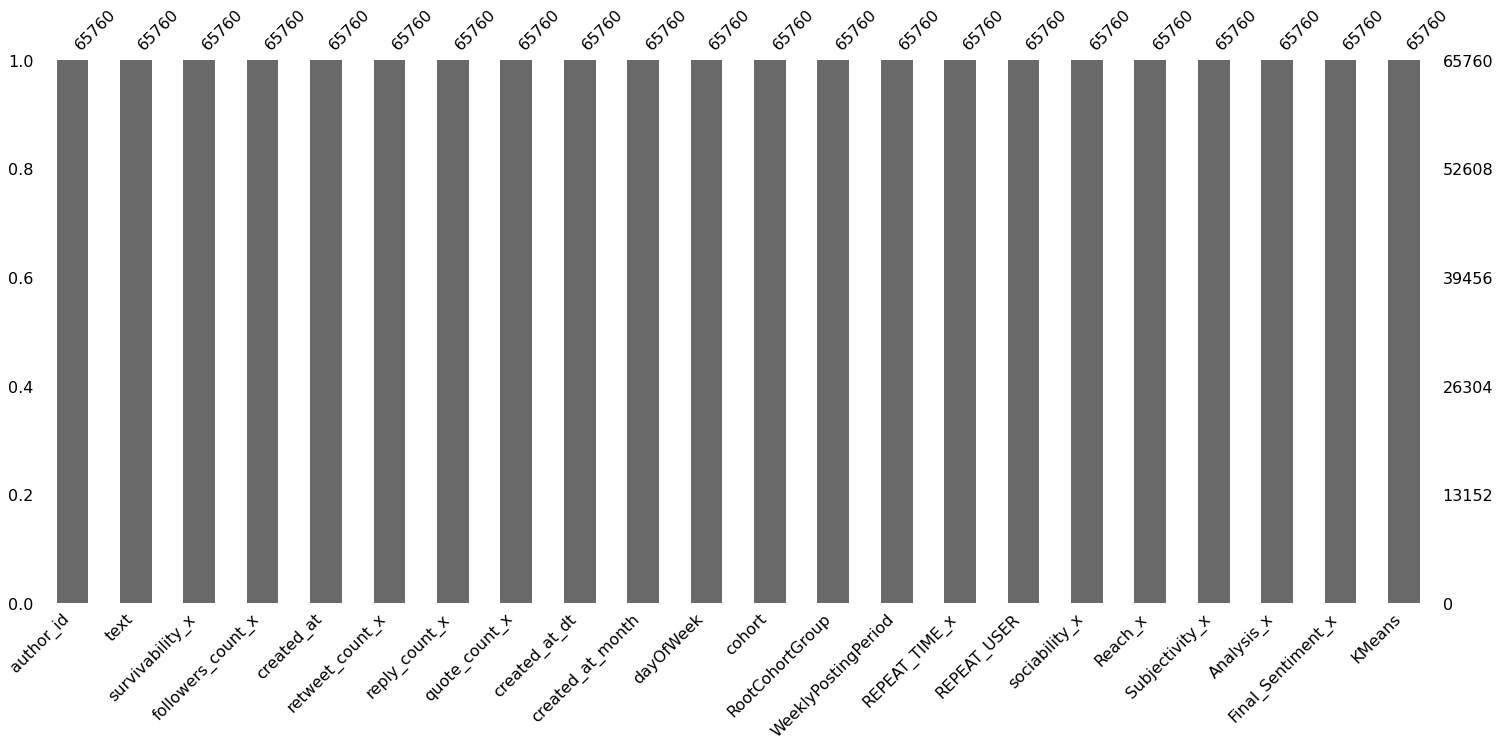

In [18]:
msno.bar(df)

There is no missind data

**Handling Meta Features**

In [19]:
# word_count

df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Unique_word_count

df['unique_word_count'] = df['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df['stop_word_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df['url_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
#df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df['char_count'] = df['text'].apply(lambda x: len(str(x)))
#df['char_count'] = df['text'].apply(lambda x: len(str(x)))

# punctuation_count
df['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#df['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

Distribution of probability density function for Meta features:

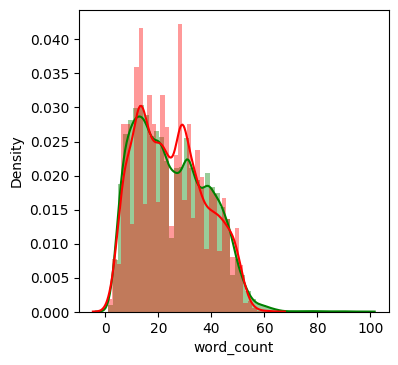

In [20]:
KMeans_tweets = df['KMeans'] == 0

fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(4,4), dpi=100)

sns.distplot(df.loc[~KMeans_tweets]['word_count'], label='', color='green')
sns.distplot(df.loc[KMeans_tweets]['word_count'], label='',  color='red')

plt.show()

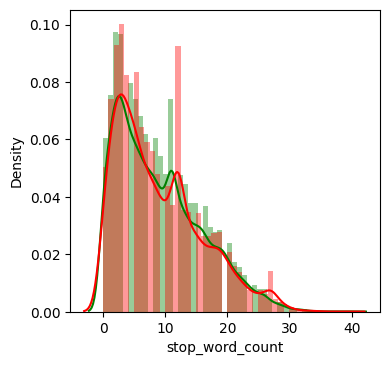

In [21]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(4,4), dpi=100)

sns.distplot(df.loc[~KMeans_tweets]['stop_word_count'], label='', color='green')
sns.distplot(df.loc[KMeans_tweets]['stop_word_count'], label='',  color='red')


plt.show()

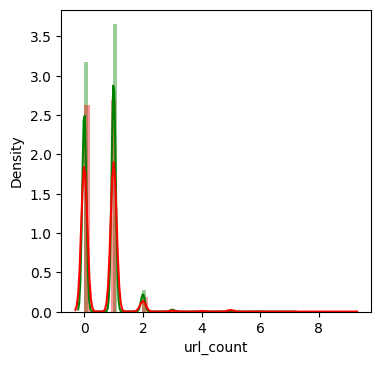

In [22]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(4,4), dpi=100)

sns.distplot(df.loc[~KMeans_tweets]['url_count'], label='', color='green')
sns.distplot(df.loc[KMeans_tweets]['url_count'], label='',  color='red')


plt.show()

# Unigrams, Bigrams and Trigrams

In [23]:
from nltk.util import ngrams

Unigrams

In [24]:
unigrams = ngrams(' '.join(df['text']).split(), 1)
nltk.FreqDist(unigrams).most_common(10)

[(('the',), 50354),
 (('to',), 38208),
 (('#StopTheSteal',), 36770),
 (('and',), 25218),
 (('of',), 19729),
 (('a',), 17853),
 (('is',), 17023),
 (('in',), 15638),
 (('for',), 14422),
 (('#stopthesteal',), 13990)]

Bigrams

In [25]:
bigrams = ngrams(' '.join(df['text']).split(), 2)
nltk.FreqDist(bigrams).most_common(10)

[(('of', 'the'), 3896),
 (('to', 'the'), 2925),
 (('in', 'the'), 2776),
 (('and', 'the'), 1928),
 (('to', 'be'), 1758),
 (('for', 'the'), 1758),
 (('President', 'Trump'), 1666),
 (('have', 'a'), 1659),
 (('This', 'is'), 1641),
 (('@realDonaldTrump', '#StopTheSteal'), 1576)]

Trigrams

In [26]:
trigrams = ngrams(' '.join(df['text']).split(), 3)
nltk.FreqDist(trigrams).most_common(10)

[(('PRESIDENT', '@realDonaldTrump', '#StopTheSteal'), 1300),
 (('WITH', 'PRESIDENT', '@realDonaldTrump'), 1285),
 (('STAND', 'WITH', 'PRESIDENT'), 1280),
 (('-', 'STAND', 'WITH'), 1261),
 (('counted', '-', 'STAND'), 1259),
 (('being', 'counted', '-'), 1246),
 (('We', 'have', 'a'), 1245),
 (('votes', 'being', 'counted'), 1240),
 (('WE', 'WILL', 'NEVER'), 1240),
 (('legitimate', 'votes', 'being'), 1235)]

# Cleaning & Preprocessing

In [27]:
import emoji

In [28]:
import emoji
def give_emoji_free_text(text):
    allchars = [str for str in text.decode('utf-8')]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.decode('utf-8').split() if not any(i in str for i in emoji_list)])
    return clean_text

In [29]:
import contractions

In [30]:
def preprocess(text_col):
    """This function will apply NLP preprocessing lambda functions over a pandas series such as df['text'].
       These functions include converting text to lowercase, removing emojis, expanding contractions, removing punctuation,
       removing numbers, removing stopwords, lemmatization, etc."""
    
    # convert to lowercase
    text_col = text_col.apply(lambda x: ' '.join([w.lower() for w in x.split()]))
    
    # remove emojis
    #text_col = text_col.apply(lambda x: emoji.replace(x, ""))
    
    # expand contractions  
    text_col = text_col.apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))

    # remove punctuation
    text_col = text_col.apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
    
    # remove numbers
    text_col = text_col.apply(lambda x: ' '.join(re.sub("[^a-zA-Z]+", " ", x).split()))

    # remove stopwords
    stopwords = [sw for sw in list(nltk.corpus.stopwords.words('english')) + ['thing'] if sw not in ['not']]
    text_col = text_col.apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords]))

    # lemmatization
    #text_col = text_col.apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(w) for w in x.split()]))

    # remove short words
    text_col = text_col.apply(lambda x: ' '.join([w.strip() for w in x.split() if len(w.strip()) >= 3]))

    return text_col

df['text'] = preprocess(df['text'])

In [31]:
#Clean the text
#Create a function to clean the tweets
def cleanTxt(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)#Remove @motions
    text = re.sub(r'#', '', text) #Removing the '#' symbol
    text = re.sub(r'RT[\s]+', '', text)#removing RT
#    text = re.sub(r'RT', '',text)# Remove the hyperlink
    text = re.sub(r'https?:\/\/\S+', '',text)
    text = re.sub(r'(http://\S*)', '',text)
    text = re.sub(r'(https://\S*)', '',text)
    text = re.sub(r'[\d-]+', '',text)
    text = re.sub(r'(@\w+)', '',text)
    text = re.sub(r'&amp;', '',text)
    text = re.sub(r'&quot;', '',text)
    text = re.sub(r'[^\w\s_-]+', '',text)
#    text = re.sub(r'(\s+)', '', text) 


    return text
#Clean the text
df['text'] = df['text'].apply(cleanTxt)

#Show the cleaned text
#df

**Addtional Cleaning**

In [32]:
def cleanTxt(text): 
            
    # Special characters
    text = re.sub(r"\x89Û_", "", text)
    text = re.sub(r"\x89ÛÒ", "", text)
    text = re.sub(r"\x89ÛÓ", "", text)
    text = re.sub(r"\x89ÛÏWhen", "When", text)
    text = re.sub(r"\x89ÛÏ", "", text)
    text = re.sub(r"China\x89Ûªs", "China's", text)
    text = re.sub(r"let\x89Ûªs", "let's", text)
    text = re.sub(r"\x89Û÷", "", text)
    text = re.sub(r"\x89Ûª", "", text)
    text = re.sub(r"\x89Û\x9d", "", text)
    text = re.sub(r"å_", "", text)
    text = re.sub(r"\x89Û¢", "", text)
    text = re.sub(r"\x89Û¢åÊ", "", text)
    text = re.sub(r"fromåÊwounds", "from wounds", text)
    text = re.sub(r"åÊ", "", text)
    text = re.sub(r"åÈ", "", text)
    text = re.sub(r"JapÌ_n", "Japan", text)    
    text = re.sub(r"Ì©", "e", text)
    text = re.sub(r"å¨", "", text)
    text = re.sub(r"SuruÌ¤", "Suruc", text)
    text = re.sub(r"åÇ", "", text)
    text = re.sub(r"å£3million", "3 million", text)
    text = re.sub(r"åÀ", "", text)


    return text
#Clean the text
df['text'] = df['text'].apply(cleanTxt)

#Show the cleaned text
#df

In [33]:
print(df.loc[[12]])

      author_id                                                         text  survivability_x  followers_count_x  created_at  retweet_count_x  reply_count_x  quote_count_x        created_at_dt created_at_month dayOfWeek      cohort RootCohortGroup  WeeklyPostingPeriod  REPEAT_TIME_x REPEAT_USER  sociability_x   Reach_x  Subjectivity_x  Analysis_x  Final_Sentiment_x  KMeans  word_count  unique_word_count  stop_word_count  url_count  mean_word_length  char_count  punctuation_count
12  1.25097e+18  tomcottonar failing object stopthesteal giving pelosi power  556              1727               2021-01-04  0                0              1              2021-01-04 20:02:08  2021-01-04       Monday    2020-12-20  2020-12-21      2                    9              Y           7.847372       0.321986  0.5             2           0.02               2       13          12                 5                0          5.846154          88          5                


In [34]:
# Cleaning based on manual data screening



def cleanTxt(text): 
            
    text = re.sub(r"httpstconhyc", "", text)
    text = re.sub(r"perezkellyk", "", text)
    text = re.sub(r"repkinzinger", "", text)
    text = re.sub(r"beijingbiden", "", text)
    text = re.sub(r"american", "", text)
    text = re.sub(r"httpstcoql", "", text)
    text = re.sub(r"let\x89Ûªs", "", text)
    text = re.sub(r"\x89Û÷", "", text)
    text = re.sub(r"\x89Ûª", "", text)
    text = re.sub(r"\x89Û\x9d", "", text)
    text = re.sub(r"å_", "", text)
    text = re.sub(r"\x89Û¢", "", text)
    text = re.sub(r"\x89Û¢åÊ", "", text)
    text = re.sub(r"fromåÊwounds", "", text)
    text = re.sub(r"åÊ", "", text)
    text = re.sub(r"åÈ", "", text)
    text = re.sub(r"JapÌ_n", "", text)    
    text = re.sub(r"Ì©", "e", text)
    text = re.sub(r"china", "", text)
    text = re.sub(r"steal", "", text)
    text = re.sub(r"yes", "", text)
    text = re.sub(r"via", "", text)
    text = re.sub(r"ali", "", text)


    return text
#Clean the text
df['text'] = df['text'].apply(cleanTxt)

#Show the cleaned text
#df

In [35]:
# Contractions

def cleanTxt(text): 

    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"We're", "We are", text)
    text = re.sub(r"That's", "That is", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"they're", "they are", text)
    text = re.sub(r"Can't", "Cannot", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"don\x89Ûªt", "do not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"What's", "What is", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"There's", "There is", text)
    text = re.sub(r"He's", "He is", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"You're", "You are", text)
    text = re.sub(r"I'M", "I am", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"i'm", "I am", text)
    text = re.sub(r"I\x89Ûªm", "I am", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"Isn't", "is not", text)
    text = re.sub(r"Here's", "Here is", text)
    text = re.sub(r"you've", "you have", text)
    text = re.sub(r"you\x89Ûªve", "you have", text)
    text = re.sub(r"we're", "we are", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"we've", "we have", text)
    text = re.sub(r"it\x89Ûªs", "it is", text)
    text = re.sub(r"doesn\x89Ûªt", "does not", text)
    text = re.sub(r"It\x89Ûªs", "It is", text)
    text = re.sub(r"Here\x89Ûªs", "Here is", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"I\x89Ûªve", "I have", text)
    text = re.sub(r"y'all", "you all", text)
    text = re.sub(r"can\x89Ûªt", "cannot", text)
    text = re.sub(r"would've", "would have", text)
    text = re.sub(r"it'll", "it will", text)
    text = re.sub(r"we'll", "we will", text)
    text = re.sub(r"wouldn\x89Ûªt", "would not", text)
    text = re.sub(r"We've", "We have", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"Y'all", "You all", text)
    text = re.sub(r"Weren't", "Were not", text)
    text = re.sub(r"Didn't", "Did not", text)
    text = re.sub(r"they'll", "they will", text)
    text = re.sub(r"they'd", "they would", text)
    text = re.sub(r"DON'T", "DO NOT", text)
    text = re.sub(r"That\x89Ûªs", "That is", text)
    text = re.sub(r"they've", "they have", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"should've", "should have", text)
    text = re.sub(r"You\x89Ûªre", "You are", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"Don\x89Ûªt", "Do not", text)
    text = re.sub(r"we'd", "we would", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"They're", "They are", text)
    text = re.sub(r"Can\x89Ûªt", "Cannot", text)
    text = re.sub(r"you\x89Ûªll", "you will", text)
    text = re.sub(r"I\x89Ûªd", "I would", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"i've", "I have", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"ain't", "am not", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"I've", "I have", text)
    text = re.sub(r"Don't", "do not", text)
    text = re.sub(r"I'll", "I will", text)
    text = re.sub(r"I'd", "I would", text)
    text = re.sub(r"Let's", "Let us", text)
    text = re.sub(r"you'd", "You would", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"Ain't", "am not", text)
    text = re.sub(r"Haven't", "Have not", text)
    text = re.sub(r"Could've", "Could have", text)
    text = re.sub(r"youve", "you have", text)  
    text = re.sub(r"donå«t", "do not", text)   



    return text
#Clean the text
df['text'] = df['text'].apply(cleanTxt)

In [36]:
def cleanTxt(text):

    # Urls
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)
        
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        text = text.replace(p, f' {p} ')
        
    # ... and ..
    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')     
    return text
#Clean the text
df['text'] = df['text'].apply(cleanTxt)

In [37]:
df['text'] = df['text'].str.replace('http[^\s]*',"")

In [38]:
df['text'] = df['text'].str.replace('https[^\s]*',"")

Removing words less than 3 characters

In [39]:
df['text'].str.split().map(lambda sl: " ".join(s for s in sl if len(s) < 3))

0         
1         
2         
3         
4        s
        ..
65755     
65756     
65757     
65758     
65759     
Name: text, Length: 65760, dtype: object

In [40]:
print(nltk.corpus.stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Topic Modeling Prep

**Preprocessing & Visualization_final**

In [41]:
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Install pysastrawi for stemming and additional stopword list.

In [42]:
!pip install pysastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Create stopword remover



In [43]:
from nltk.tokenize import word_tokenize
factory = StopWordRemoverFactory()
STOPWORDS_2 = factory.create_stop_word_remover()

In [44]:
stop_words = nltk.corpus.stopwords.words('english')

In [45]:
STOPWORDS = set(stopwords.words("english"))
second_list = ('stopthesteal', 'Stopthesteal', 'stopthestea', 'StoptheSteal', 'realdonaldtrump', 'not', 'trump', 'election', "stopthesteal","trump","not","realdonaldtrump","realdonaldtrump","amp","maga",
              "president","httpstco","people","gop","fraud","votes","stand","right",
              "america","biden","fightfortrump","patriots","georgia", 'one', 'get', 'like', 'steal', 'ali', 'via', 'yes', 'senatorromney', 'jan', 'January', 'senatemajldr', 'stopthe', 'ccp', 'never', 'never', 'january', 'stop'
              "stopthe", "also", "see", 
               "joe", "obama", "potus", "powel", "scott", "sidney", "tracybeanz", "donald" "ing", "rudygiuliani", "sidneypowell", "hawleymo", "joebiden", "man", "msm", "stopthesteai", "two", 
               'sentedcruz', 'johncornyn', 'let', 'usa', 'let', 'would', 'would', 'newsmax', 'can', 'not', 'take', 'back')
STOPWORDS = STOPWORDS.union(STOPWORDS_2.dictionary.words, second_list)

Create a function to stem and remove stopwords from text.

In [46]:
def text_stemmer(text: str):
    stem = []
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    word_token = word_tokenize(text)
    stemmed = [stemmer.stem(word) for word in word_token]
    stem = ' '.join(stemmed)
    return stem

Create a function to tokenize words from text.



In [47]:
from gensim.utils import simple_preprocess
def tokenizer(text):
    result = []
    for token in simple_preprocess(text):
      result.append(token)
    return result

Apply stemmer and stopword remover to dataset.



In [48]:
df["text"] = df["text"].apply(text_stemmer) # takes too long

In [49]:
#df.head(5)

In [50]:
print(df.loc[[2]])

    author_id                                                                                                                            text  survivability_x  followers_count_x  created_at  retweet_count_x  reply_count_x  quote_count_x        created_at_dt created_at_month dayOfWeek      cohort RootCohortGroup  WeeklyPostingPeriod  REPEAT_TIME_x REPEAT_USER  sociability_x  Reach_x  Subjectivity_x  Analysis_x  Final_Sentiment_x  KMeans  word_count  unique_word_count  stop_word_count  url_count  mean_word_length  char_count  punctuation_count
2  17240656.0  dave larock fair censured fact participated number orgies dysfunction racism obeisance efillercorn pricefordel marcussimon fib  532              394                2021-01-28  2                1              0              2021-01-28 23:54:51  2021-01-28       Thursday  2021-01-28  2021-02-01      3                    1              N           6.862761       0.39862  0.9             2           0.01               1       37         

**Generate wordcloud**

In [51]:
from wordcloud import WordCloud 

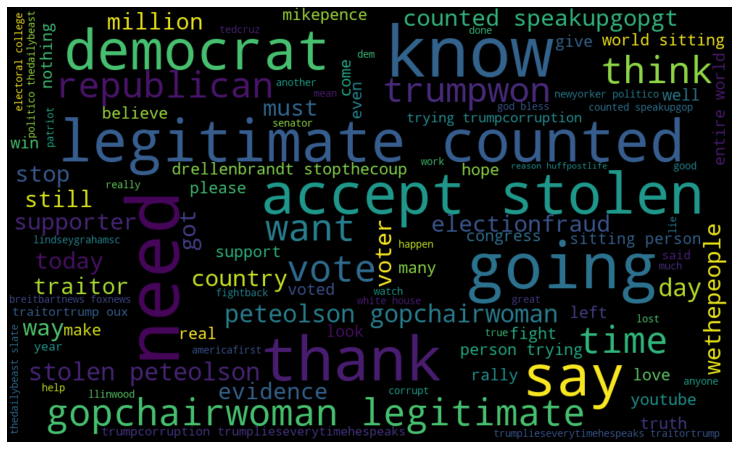

In [52]:
tweet_text = df["text"]
tweet_text = " ".join(tweet_text.to_list())
tweet_text_wordcloud = WordCloud(width=1000,
                                    height=600,
                                    max_font_size=100,
                                    max_words=100,
                                    background_color="black").generate(tweet_text)
plt.figure(figsize=(15,8))
plt.imshow(tweet_text_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [53]:
visualization = df.copy()
visualization["num_word"] = df["text"].apply(lambda x: len(str(x).split()))

In [54]:
import seaborn as sns

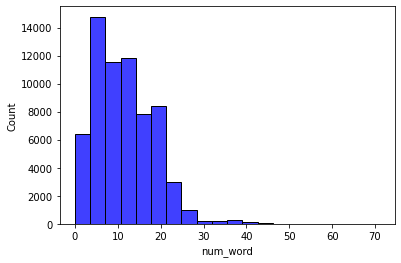

In [55]:
sns.histplot(data=visualization, x="num_word", bins=20, color="blue")

As shown from graph above, most of headline news have 10 to 30 words.

Bellow we look for 20 most common words that appear in news headline.

In [56]:
from collections import Counter

In [57]:
visualization["word_list"] = visualization["text"].apply(lambda x: str(x).split())
common_words = Counter([item for sublist in visualization["word_list"] for item in sublist])

# 20 most common words 
temp = pd.DataFrame(common_words.most_common(20))
temp.columns = ["common_words", "count"]
temp.style.background_gradient(cmap="Blues")

,common_words,count
0,stop,2553
1,vote,2428
2,know,2420
3,fight,2372
4,time,2351
5,stolen,2315
6,need,2078
7,going,2024
8,support,2004
9,thank,1985


Next we create tokenized data by applying tokenizer function.

In [58]:
data_preprocessed = df["text"].map(tokenizer)

Create dictionary from tokenized data.



In [59]:
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel, TfidfModel
from pprint import pprint
import gensim

id2word = Dictionary(data_preprocessed)

### Dictionary & Corpus

In [60]:
# Create dictionary and corpus needed for topic modeling

# dictionary is a mapping of word_id --> word, as the variable name implies
id2word = corpora.Dictionary(data_preprocessed)
id2word.filter_extremes(no_below=15, no_above=0.4, keep_n=80000)

# the preprocessed and lemmatized documents themselves
texts = data_preprocessed

# corpus is a mapping of word_id --> word frequency
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [61]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('antifa', 1),
  ('infiltrated', 1),
  ('know', 1),
  ('many', 1),
  ('protests', 1)]]

## Latent Dirichlet Allocation (LDA)

In [62]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

In [63]:
# Print the Keyword in the 3 topics
pprint(lda_model.show_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.016*"stop" + 0.012*"time" + 0.011*"country" + 0.010*"please" + '
  '0.010*"thank" + 0.009*"world" + 0.008*"way" + 0.008*"bill" + 0.008*"needs" '
  '+ 0.007*"help"'),
 (1,
  '0.021*"vote" + 0.020*"know" + 0.017*"need" + 0.015*"want" + 0.014*"voter" + '
  '0.013*"states" + 0.011*"think" + 0.011*"even" + 0.010*"got" + 0.010*"make"'),
 (2,
  '0.019*"support" + 0.016*"fight" + 0.012*"going" + 0.012*"must" + '
  '0.009*"can" + 0.009*"not" + 0.009*"state" + 0.008*"rally" + 0.007*"great" + '
  '0.007*"democrats"')]


### Model Evaluation Metrics

In [64]:
from gensim.models import CoherenceModel

# Compute Perplexity (lower is better)
print('Perplexity: ', round(lda_model.log_perplexity(corpus), 2))

# Compute Coherence Score (higher is better)
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_preprocessed, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', round(coherence_lda, 2))

Perplexity:  -8.32
Coherence Score:  0.13


### Finding the most dominant topic in each sentence

In [65]:
def get_dominant_topics(ldamodel=lda_model, corpus=corpus, texts=texts):
    sent_topics_df = pd.DataFrame()

    # Get dominant topic in each document and the probability associated with it
    for i, row in enumerate(ldamodel[corpus]):
        try:
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
        except:
            row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        dom_topic = row[0]
        topic_num, topic_rep = dom_topic
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(topic_rep,4)]), ignore_index=True)
    sent_topics_df.columns = ['Dominant_Topic', 'Topic_Rep']
    sent_topics_df['Dominant_Topic'] = sent_topics_df['Dominant_Topic'].astype(int)
    return(sent_topics_df)

df_with_topics = get_dominant_topics(ldamodel=lda_model, corpus=corpus, texts=texts)
lda_df = pd.concat([df, df_with_topics], axis=1)
lda_df.head(3)

,author_id,text,survivability_x,followers_count_x,created_at,retweet_count_x,reply_count_x,quote_count_x,created_at_dt,created_at_month,dayOfWeek,cohort,RootCohortGroup,WeeklyPostingPeriod,REPEAT_TIME_x,REPEAT_USER,sociability_x,Reach_x,Subjectivity_x,Analysis_x,Final_Sentiment_x,KMeans,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,Dominant_Topic,Topic_Rep
0,9.03752e+17,ofpeopl agargmd many know protests infiltrated antifa,532,1771,2021-01-28,0,0,0,2021-01-28 23:59:15,2021-01-28,Thursday,2021-01-28,2021-02-01,3,1,N,8.182559,0.265585,0.500000,2,0.02,2,13,13,4,0,6.384615,95,3,0,0.3696
1,2518375567.0,say shocked naiveignorant many complaining robinhood etrade etc stopping opening new positions gme others qanon,532,4,2021-01-28,0,0,0,2021-01-28 23:55:00,2021-01-28,Thursday,2021-01-28,2021-02-01,3,1,N,3.669951,0.568682,0.584848,0,0.00,0,33,32,16,0,5.151515,202,9,0,0.5365
2,17240656.0,dave larock fair censured fact participated number orgies dysfunction racism obeisance efillercorn pricefordel marcussimon fib,532,394,2021-01-28,2,1,0,2021-01-28 23:54:51,2021-01-28,Thursday,2021-01-28,2021-02-01,3,1,N,6.862761,0.398620,0.900000,2,0.01,1,37,32,16,1,5.513514,240,19,2,0.4678


In [66]:
lda_df['Dominant_Topic'].unique()

array([0, 2, 1])

In [67]:
#lda_df[lda_df['Dominant_Topic'] == 0]

**LDA Mallet Model**

In [68]:
lda_model = gensim.models.ldamodel.LdaModel(
   corpus=corpus, id2word=id2word, num_topics=6, random_state=20, 
   update_every=1, chunksize=100, passes=20, alpha='auto', per_word_topics=True)

In [69]:
# Show Topics
pprint(lda_model.show_topics(num_words=30, formatted=False)[:3])

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=lda_model, texts=data_preprocessed, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

print('Coherence Score: ', round(coherence_ldamallet, 2))

[(0,
  [('support', 0.025778415),
   ('stop', 0.02139956),
   ('know', 0.017778395),
   ('please', 0.014013863),
   ('world', 0.011802088),
   ('way', 0.011463365),
   ('fightback', 0.010081455),
   ('llinwood', 0.009324852),
   ('give', 0.009015047),
   ('holdtheline', 0.00894658),
   ('wethepeople', 0.00846867),
   ('god', 0.008300321),
   ('trying', 0.00725748),
   ('years', 0.0071502835),
   ('freedom', 0.0071253167),
   ('big', 0.0069774953),
   ('believe', 0.006846496),
   ('sign', 0.006826343),
   ('wakeupamerica', 0.0067745172),
   ('voting', 0.006456972),
   ('ever', 0.006455935),
   ('live', 0.0063768323),
   ('bidencheated', 0.0063369786),
   ('video', 0.0062027397),
   ('senate', 0.006132107),
   ('true', 0.005903486),
   ('jennaellisesq', 0.0058419746),
   ('electionfraud', 0.005464593),
   ('still', 0.0053715915),
   ('better', 0.005345019)]),
 (1,
  [('vote', 0.044540178),
   ('state', 0.028499193),
   ('got', 0.021590557),
   ('million', 0.01957523),
   ('law', 0.019419

**Bisualization of Topics within Clusters**

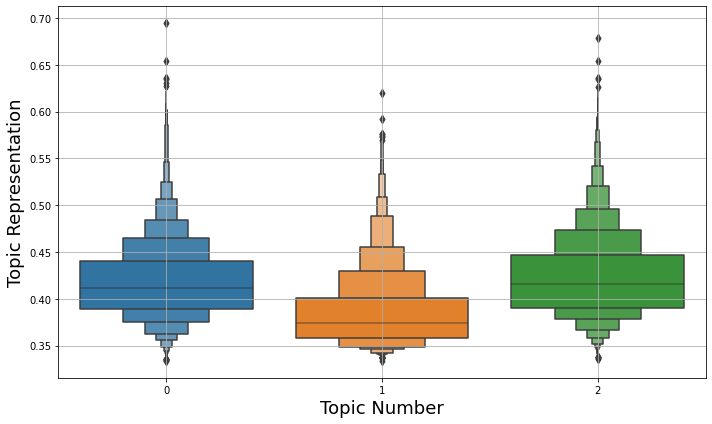

In [70]:
import seaborn as sns
fig = plt.figure(figsize=(10,6))
sns.boxenplot(data=lda_df, y='Topic_Rep', x='Dominant_Topic')
plt.xlabel('Topic Number', fontsize=18)
plt.ylabel('Topic Representation', fontsize=18)
plt.tight_layout()
plt.grid()

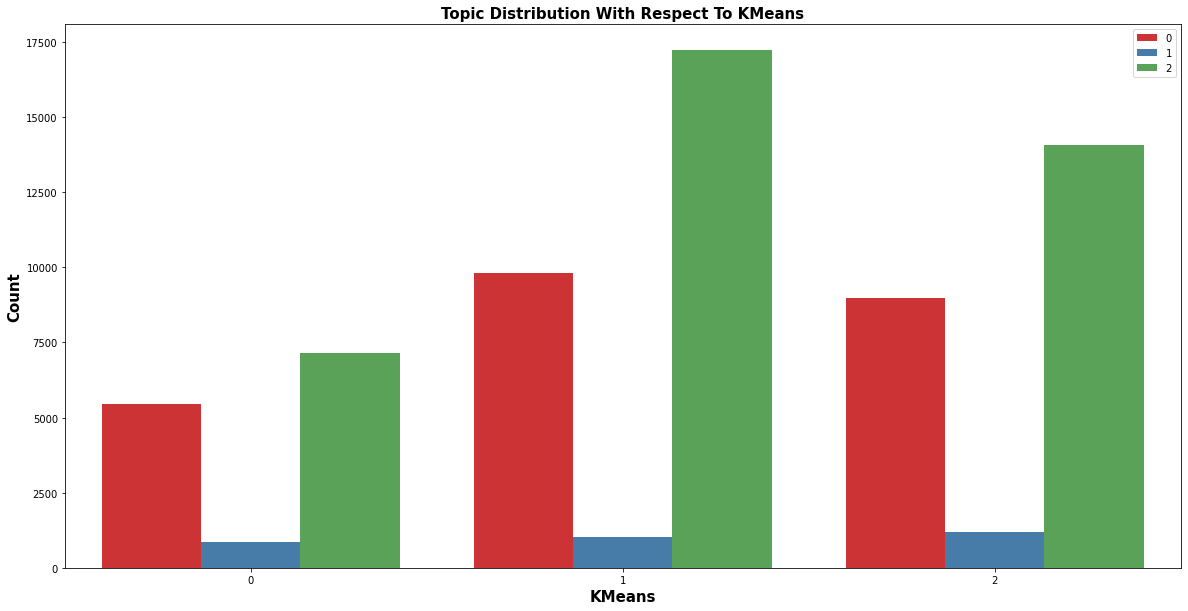

In [71]:
plt.figure(figsize=(20,10))
sns.countplot(lda_df['KMeans'], hue=lda_df['Dominant_Topic'], palette = 'Set1',)
plt.legend(loc='upper right')
plt.ylabel('Count', fontsize=15, fontweight='bold')
plt.xlabel('KMeans', fontsize=15, fontweight='bold')
plt.title('Topic Distribution With Respect To KMeans', fontsize=15, fontweight='bold')
plt.show()

Topics in respect to KMeans Clusters across all periods

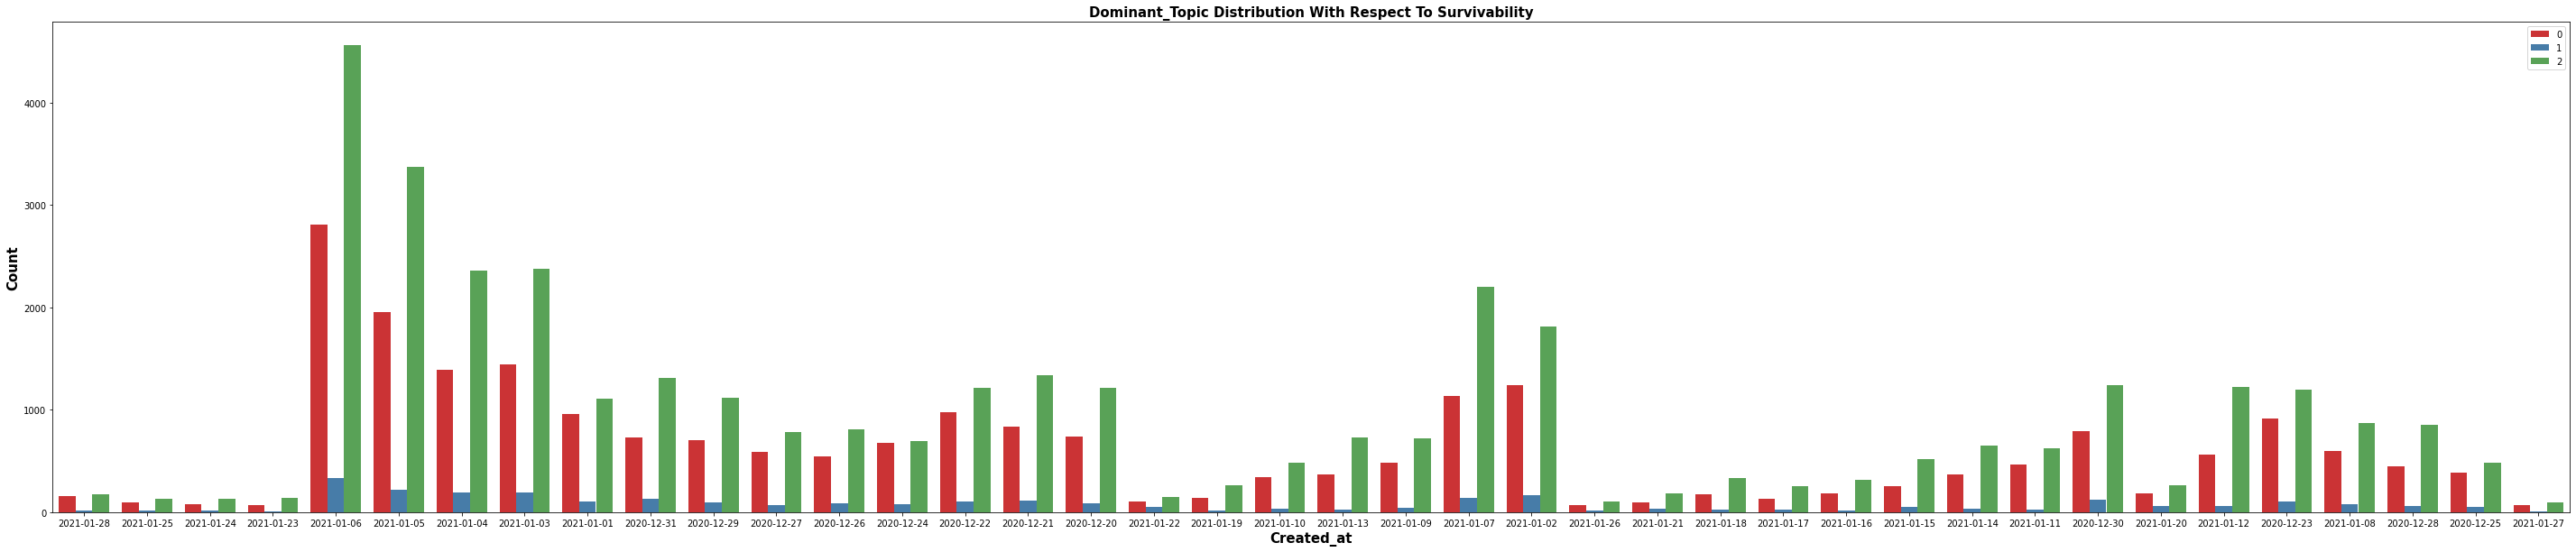

In [72]:
plt.figure(figsize=(50,10))
sns.countplot(lda_df['created_at'], hue=lda_df['Dominant_Topic'], palette = 'Set1')
plt.legend(loc='upper right')
plt.ylabel('Count', fontsize=15, fontweight='bold')
plt.xlabel('Created_at', fontsize=15, fontweight='bold')
plt.title('Dominant_Topic Distribution With Respect To Survivability', fontsize=15, fontweight='bold')
plt.show()

In [73]:
# Filter data between two dates
filtered_df = lda_df.loc[(lda_df['created_at'] >= '2020-12-29')
                     & (df['created_at'] < '2021-01-07')]
# Display
filtered_df

,author_id,text,survivability_x,followers_count_x,created_at,retweet_count_x,reply_count_x,quote_count_x,created_at_dt,created_at_month,dayOfWeek,cohort,RootCohortGroup,WeeklyPostingPeriod,REPEAT_TIME_x,REPEAT_USER,sociability_x,Reach_x,Subjectivity_x,Analysis_x,Final_Sentiment_x,KMeans,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,Dominant_Topic,Topic_Rep
8,1.25097e+18,senatortimscott senator fails needs primaried,555,1727,2021-01-06,0,0,0,2021-01-06 01:50:41,2021-01-06,Wednesday,2020-12-20,2020-12-21,3,5,Y,7.847372,0.321986,0.300000,0,0.00,2,13,12,6,0,5.692308,86,3,1,0.3599
9,1.25097e+18,installed might well shred constitution longer matter since watched republic fall republicans complicit failed,555,1727,2021-01-06,0,0,0,2021-01-06 01:04:30,2021-01-06,Wednesday,2020-12-20,2020-12-21,3,6,Y,7.847372,0.321986,0.300000,0,0.00,2,36,35,21,0,5.611111,237,9,2,0.4309
10,1.25097e+18,tomcottonar coming neighborhood near soon thanks democrats cheated spineless ros tom,555,1727,2021-01-05,0,0,0,2021-01-05 20:09:05,2021-01-05,Tuesday,2020-12-20,2020-12-21,3,7,Y,7.847372,0.321986,0.200000,2,0.01,2,31,27,12,0,5.193548,191,9,2,0.5595
11,1.25097e+18,travesty thejusticedept investigate prosecute blatant occurring states conveniently stopped counting cue winning landslide tfxc,556,1727,2021-01-04,1,1,1,2021-01-04 20:34:37,2021-01-04,Monday,2020-12-20,2020-12-21,2,8,Y,7.847372,0.393187,0.540179,2,0.01,2,37,32,14,1,6.675676,283,16,0,0.4758
12,1.25097e+18,tomcottonar failing object giving los power,556,1727,2021-01-04,0,0,1,2021-01-04 20:02:08,2021-01-04,Monday,2020-12-20,2020-12-21,2,9,Y,7.847372,0.321986,0.500000,2,0.02,2,13,12,5,0,5.846154,88,5,2,0.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61745,615541871.0,markfinchem michaelcoudrey scottpresler raheemkassam kelliwardaz drpaulgosar anthonykernaz eagleedmartin called guys times today including ducy keep going sign recall petitions rally wed,563,523,2020-12-29,0,0,0,2020-12-29 00:29:11,2020-12-29,Tuesday,2020-12-29,2021-01-04,2,1,N,7.254179,0.359534,0.000000,1,-0.00,2,36,36,8,0,7.055556,299,17,0,0.4571
61746,8.99022e+17,gopchairwoman elliottechols republicans biggest failure entire mess knew coming prevent cheating reported can not prove nofight,563,2905,2020-12-29,0,0,0,2020-12-29 00:25:13,2020-12-29,Tuesday,2020-12-29,2021-01-04,2,1,N,7.977968,0.340975,0.366667,0,0.00,2,32,30,14,0,5.687500,213,14,2,0.4931
61747,1.34226e+18,,563,769,2020-12-29,0,0,0,2020-12-29 00:21:46,2020-12-29,Tuesday,2020-12-29,2021-01-04,2,1,N,7.084228,0.397744,0.000000,1,-0.03,1,2,2,0,1,17.500000,36,5,2,0.3873
61748,4364906843.0,skyrider gojackflynn ericmetaxas malachiobrien llinwood sandrasentinel steph katthehammer randpaul jennaellisesq carrerapulse plan country democrats got away russian hoax impeachment voter ones stop voices must heard drain swamp,563,35,2020-12-29,0,0,0,2020-12-29 00:13:51,2020-12-29,Tuesday,2020-12-29,2021-01-04,2,1,N,5.468181,0.417069,0.500000,1,-0.00,1,57,51,25,0,6.035088,400,20,2,0.3912


In [74]:
filtered_df["Dominant_Topic"] = filtered_df["Dominant_Topic"].map({0: "Topic_0: stop, time, country, please, thank, world, way, bill, needs, help", 1: 'Topic_1: vote, know, need, want, boter, states, think, even, got, make', 2: 'Topic_2: support, fight, going, must, can, not, state, rally, great, democrats'})

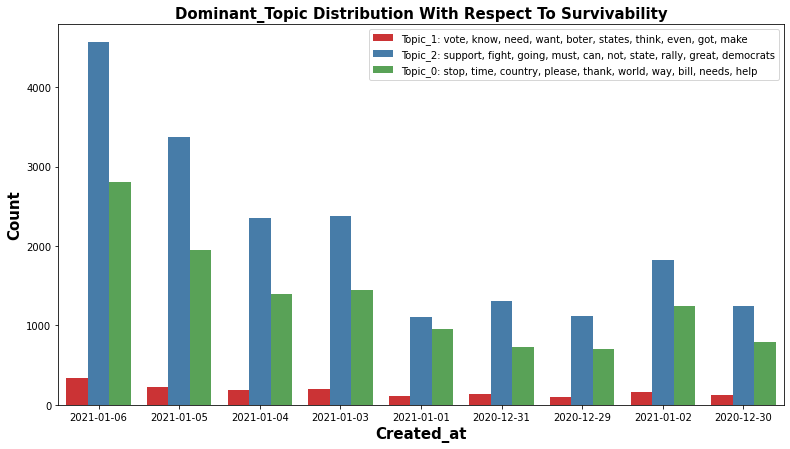

In [75]:
plt.figure(figsize=(13,7))
sns.countplot(filtered_df['created_at'], hue=filtered_df['Dominant_Topic'], palette = 'Set1')
plt.legend(loc='upper right')
plt.ylabel('Count', fontsize=15, fontweight='bold')
plt.xlabel('Created_at', fontsize=15, fontweight='bold')
plt.title('Dominant_Topic Distribution With Respect To Survivability', fontsize=15, fontweight='bold')
plt.show()

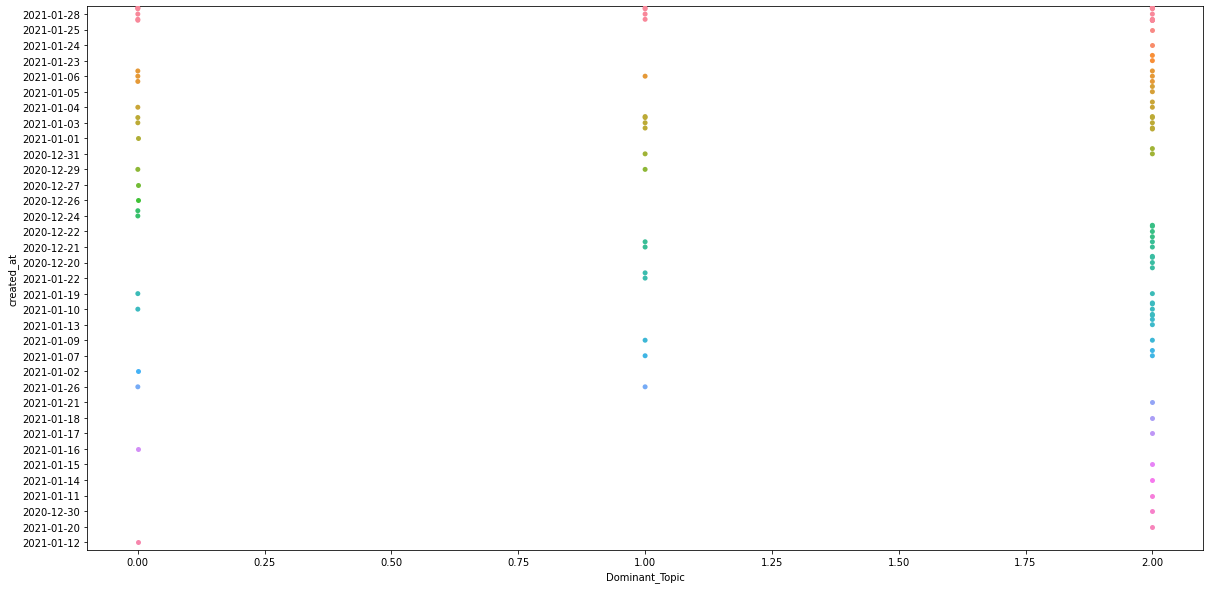

In [76]:
mini_df = lda_df.iloc[:100]
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
ax = sns.swarmplot(data=mini_df, x='Dominant_Topic', y='created_at');

**Calculating Term Probabliity Distribution by Cluster**

In [77]:
analysis_df = []
for topic_id in range(0, 3):
    for cluster_id in range(0, 3):
        topic_dist = lda_model.show_topic(topic_id, topn=50)
        docs_in_cluster = lda_df['text'][lda_df['KMeans'] == cluster_id]
        for term, proba in topic_dist:
            num_docs = (docs_in_cluster.str.count(term) > 0).sum()
            analysis_df.append([topic_id, cluster_id, term, proba, num_docs])

analysis_df = pd.DataFrame(analysis_df, columns=['Topic', 'Cluster', 'Term', 'Term Proba', 'Num Docs'])


# Add original text to the end of the output
contents = pd.Series(texts)
analysis_df = pd.concat([analysis_df, contents], axis=1)
#analysis_df

In [78]:
analysis_df[0:900][['Topic', 'Cluster', 'Term', 'Num Docs', 'text']].to_csv('Mapping_to_text.csv')

In [79]:
analysis_df_2 = pd.DataFrame(analysis_df, columns=['Cluster', 'Topic', 'Term', 'Term Proba', 'Num Docs'])

In [80]:
analysis_df_2.head()

,Cluster,Topic,Term,Term Proba,Num Docs
0,0.0,0.0,support,0.025778,759.0
1,0.0,0.0,stop,0.021400,1242.0
2,0.0,0.0,know,0.017778,549.0
3,0.0,0.0,please,0.014014,332.0
4,0.0,0.0,world,0.011802,860.0


Find to which cluster highest number of docs a specific term is found. 

find the top 50 terms of each topic, then you can eleminate the terms that are across each topic. 



In [81]:
analysis_df.sort_values(['Topic', 'Term','Cluster', 'Num Docs'])

,Topic,Cluster,Term,Term Proba,Num Docs,text
41,0.0,0.0,amacforamerica,0.004311,52.0,"[called, fury]"
91,0.0,1.0,amacforamerica,0.004311,35.0,"[topread, last, week, future, postelection, trajectories, rightwing, mobilization, lzigve]"
141,0.0,2.0,amacforamerica,0.004311,24.0,"[know, means, everyone, know, phrase, yixing, revolution, cultural, revolution, means, impeachbiden, bidencheated, wakeupamerica, patriotsunited]"
48,0.0,0.0,arizona,0.004086,90.0,"[milwaukeeforev, influenstrategy, cnn, aoc, peoples, actions, make, cruz, responsible, shit, want, expel, need, expel, los, waters, apparently, jobs, illegal, expel, lords, leaders, good, though]"
98,0.0,1.0,arizona,0.004086,209.0,"[brithume, washington, monument, sticking, middle, finger, million, legitimately, voted]"
...,...,...,...,...,...,...
65755,NaN,NaN,NaN,NaN,NaN,"[ing, every, fukken]"
65756,NaN,NaN,NaN,NaN,NaN,"[realjameswoods, actually, counted, folds]"
65757,NaN,NaN,NaN,NaN,NaN,"[repmobrooks, jimjordan, devinnunes, tedcruz, randpaul, marshablackburn, repmattgaetz, senjohnkennedy, tomcottonar, expect, stop, certification, process, period, jobs]"
65758,NaN,NaN,NaN,NaN,NaN,"[gopchairwoman, think, effective, thanks, gopchairwoman]"


In [82]:
# save to csv
analysis_df.sort_values(['Topic', 'Term', 'Cluster', 'Num Docs']).head().to_csv("grouping_topic_cluster.csv")

In [83]:
groupings_df = analysis_df.sort_values(['Topic', 'Term', 'Cluster']) \
    .sort_values('Num Docs', ascending=False) \
    .groupby(['Topic', 'Term']) \
    .agg('first')

In [84]:
groupings_df.head()

Cluster  Term Proba  Num Docs                                                                                                                                                                             text
Topic Term                                                                                                                                                                                                                          
0.0   amacforamerica  0.0      0.004311    52.0      [called, fury]                                                                                                                                                                 
      arizona         1.0      0.004086    209.0     [brithume, washington, monument, sticking, middle, finger, million, legitimately, voted]                                                                                       
      believe         2.0      0.006846    403.0     [long, threadhorror, documenting, inciter, laurenboebert, might, want, turn, volume, voice, grates, last, nerve, mine]                                                         
      best            2.0      0.004153    284.0     [subtitles, ccps, invade, neighboring, countries, another, migrating, large, number, han, chinese, robbing, land, resources, impeachbiden, quidprojoe, bidencheated]           
      better          2.0      0.005345    384.0     [true, instructed, top, military, executives, important, security, issue, combating, global, warming, impeachbiden, bidencheated, wakeupamerica, patriotsunited, secretempires]

In [85]:
groupings_df.reset_index()[['Topic', 'Cluster', 'Term']].pivot_table(values='Term', index='Topic', columns='Cluster', aggfunc=lambda x: ', '.join(x))   #.to_csv('mapping.csv')

Cluster,0.0,1.0,2.0
Topic,,,
0.0,"amacforamerica, matures, trying, world","arizona, bidencheated, demand, draintheswamp, ever, fraudulent, give, god, hope, jennaellisesq, know, last, llinwood, lose, may, petition, please, sign, tedcruz, true, video, voting, well, wethepeople, years","believe, best, better, big, electionfraud, fightback, fightlikeaflynn, follow, free, freedom, gatewaypundit, holdtheline, live, randpaul, senate, still, stop, support, use, wakeupamerica, way"
1.0,"bad, democracy, foxnews, order, person, post, recount, traitor","called, cernovich, chance, concede, counsel, counting, democrat, dems, dollars, else, everything, got, landslide, law, martial, million, new, news, problem, put, ready, rick, say, senator, state, tax, victory, vote, voted, wake","anyone, call, college, electoral, media, patriot, republican, run, senrickscott, voters, washington, winning"
2.0,corrupt,"another, around, communist, could, country, elections, every, evidence, fighting, first, genflynn, great, happen, help, ing, integrity, join, made, money, must, need, needs, pres, really, remember, rigged, ros, said, standing, sure, tell, time, trumps, wants","care, congress, coup, enough, even, fight, kag, latest, much, part, party, presidential, senators, voter, yet"


Link to cell to update stop words

https://colab.research.google.com/drive/1prJE8TBhbKgiORzmAJzmbhk8xo8lOxRa#scrollTo=M4-KsxzuumnZ&line=3&uniqifier=1

**WITHOUT CLUSTER**

In [86]:
analysis_df = pd.DataFrame(analysis_df, columns=['Topic', 'Term', 'Term Proba', 'Num Docs'])


Find to which cluster highest number of docs a specific term is found.

find the top 50 terms of each topic, then you can eleminate the terms that are across each topic.

In [87]:
analysis_df.sort_values(['Topic', 'Term', 'Num Docs']).head(10)

,Topic,Term,Term Proba,Num Docs
141,0.0,amacforamerica,0.004311,24.0
91,0.0,amacforamerica,0.004311,35.0
41,0.0,amacforamerica,0.004311,52.0
48,0.0,arizona,0.004086,90.0
148,0.0,arizona,0.004086,160.0
98,0.0,arizona,0.004086,209.0
16,0.0,believe,0.006846,189.0
66,0.0,believe,0.006846,394.0
116,0.0,believe,0.006846,403.0
46,0.0,best,0.004153,218.0


In [88]:
# save to csv
analysis_df.sort_values(['Topic', 'Term', 'Num Docs']).head().to_csv("grouping_topic_cluster.csv")

In [89]:
groupings_df = analysis_df.sort_values(['Topic', 'Term']) \
    .sort_values('Num Docs', ascending=False) \
    .groupby(['Topic', 'Term']) \
    .agg('first')

In [90]:
groupings_df.head()

Term Proba  Num Docs
Topic Term                                
0.0   amacforamerica  0.004311    52.0    
      arizona         0.004086    209.0   
      believe         0.006846    403.0   
      best            0.004153    284.0   
      better          0.005345    384.0

In [91]:
groupings_df.reset_index()[['Topic', 'Num Docs', 'Term']].pivot_table(values='Term', index='Topic', columns='Topic', aggfunc=lambda x: ', '.join(x))

Topic,0.0,1.0,2.0
Topic,,,
0.0,"amacforamerica, arizona, believe, best, better, bidencheated, big, demand, draintheswamp, electionfraud, ever, fightback, fightlikeaflynn, follow, fraudulent, free, freedom, gatewaypundit, give, god, holdtheline, hope, jennaellisesq, know, last, live, llinwood, lose, matures, may, petition, please, randpaul, senate, sign, still, stop, support, tedcruz, true, trying, use, video, voting, wakeupamerica, way, well, wethepeople, world, years",NaN,NaN
1.0,NaN,"anyone, bad, call, called, cernovich, chance, college, concede, counsel, counting, democracy, democrat, dems, dollars, electoral, else, everything, foxnews, got, landslide, law, martial, media, million, new, news, order, patriot, person, post, problem, put, ready, recount, republican, rick, run, say, senator, senrickscott, state, tax, traitor, victory, vote, voted, voters, wake, washington, winning",NaN
2.0,NaN,NaN,"another, around, care, communist, congress, corrupt, could, country, coup, elections, enough, even, every, evidence, fight, fighting, first, genflynn, great, happen, help, ing, integrity, join, kag, latest, made, money, much, must, need, needs, part, party, pres, presidential, really, remember, rigged, ros, said, senators, standing, sure, tell, time, trumps, voter, wants, yet"


# Additional Analysis

 The most representative document for each topic

In [92]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = analysis_df.groupby('Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Term Proba'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Cluster', "Topic", "Term", 'Document']

# Show
sent_topics_sorteddf_mallet.head()

,Cluster,Topic,Term,Document
0,0.0,support,0.025778,759.0
1,1.0,vote,0.044540,1487.0
2,2.0,fight,0.033987,879.0


Topic distribution across documents

The volume and distribution of topics in order to judge how widely it was discussed.

In [93]:
# Number of Documents for Each Topic
topic_counts = analysis_df['Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = analysis_df[['Topic', 'Term']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Topic', 'Term', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(10)

,Topic,Term,Num_Documents,Perc_Documents
0.0,0.0,support,150.0,0.3333
1.0,0.0,stop,150.0,0.3333
2.0,0.0,know,150.0,0.3333
3.0,0.0,please,NaN,NaN
4.0,0.0,world,NaN,NaN
5.0,0.0,way,NaN,NaN
6.0,0.0,fightback,NaN,NaN
7.0,0.0,llinwood,NaN,NaN
8.0,0.0,give,NaN,NaN
9.0,0.0,holdtheline,NaN,NaN


In [94]:
print(df_dominant_topics.loc[[100]])

     Topic     Term  Num_Documents  Perc_Documents
100  0.0    support NaN            NaN            


Finding the dominant topic in each tweet

In [95]:
analysis_df_new = []
for topic_id in range(0, 3):
    for cluster_id in range(0, 3):
        topic_dist = lda_model.show_topic(topic_id, topn=50)
        docs_in_cluster = lda_df['text'][lda_df['KMeans'] == cluster_id]
        for term, proba in topic_dist:
            num_docs = (docs_in_cluster.str.count(term) > 0).sum()
            analysis_df.append([topic_id, cluster_id, term, proba, num_docs])
analysis_df_new = pd.DataFrame(analysis_df, columns=['Topic', 'cluster_id', 'Term', 'Term Proba', 'Num Docs'])

analysis_df_new.columns = ['Topic', 'cluster_id', 'Term', 'Term Proba', 'Num Docs']

# Add original text to the end of the output
contents = pd.Series(texts)
analysis_df_new = pd.concat([analysis_df_new, contents], axis=1)


In [96]:
analysis_df_new

,Topic,cluster_id,Term,Term Proba,Num Docs,text
0,0.0,NaN,support,0.025778,759.0,"[ofpeopl, agargmd, many, know, protests, infiltrated, antifa]"
1,0.0,NaN,stop,0.021400,1242.0,"[say, shocked, naiveignorant, many, complaining, robinhood, etrade, etc, stopping, opening, new, positions, gme, others, qanon]"
2,0.0,NaN,know,0.017778,549.0,"[dave, larock, fair, censured, fact, participated, number, orgies, dysfunction, racism, obeisance, efillercorn, pricefordel, marcussimon, fib]"
3,0.0,NaN,please,0.014014,332.0,"[govkristinoem, notmypresident, ilegitamate]"
4,0.0,NaN,world,0.011802,860.0,"[could, worked, retained, helped, instead, hurting, uniparty, ros, romney, wanted, install, instead]"
...,...,...,...,...,...,...
65755,NaN,NaN,NaN,NaN,NaN,"[ing, every, fukken]"
65756,NaN,NaN,NaN,NaN,NaN,"[realjameswoods, actually, counted, folds]"
65757,NaN,NaN,NaN,NaN,NaN,"[repmobrooks, jimjordan, devinnunes, tedcruz, randpaul, marshablackburn, repmattgaetz, senjohnkennedy, tomcottonar, expect, stop, certification, process, period, jobs]"
65758,NaN,NaN,NaN,NaN,NaN,"[gopchairwoman, think, effective, thanks, gopchairwoman]"


In [97]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = analysis_df_new.groupby('Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Term Proba'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Cluster", "Term", "Term Proba", "Num Docs", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Cluster,Term,Term Proba,Num Docs,Text
0,0.0,NaN,support,0.025778,759.0,"[ofpeopl, agargmd, many, know, protests, infiltrated, antifa]"
1,1.0,NaN,vote,0.044540,1487.0,"[otherwise, less, show, new, real, vote, count, approval, rating, exposed, impeachbiden, quidprojoe, bidencheated, wakeupamerica]"
2,2.0,NaN,fight,0.033987,879.0,"[dabbs, chuck, todd, goes, rude, democrat, operative, mouthbreathing, libotards, miss, mansions]"


# Additional Analysis

In [98]:
Kmeans_0 = lda_df[lda_df['KMeans'] == 0]

KMeans0

In [99]:
K0_visualization = Kmeans_0.copy()
K0_visualization["num_word"] = Kmeans_0["text"].apply(lambda x: len(str(x).split()))

In [100]:
K0_visualization["word_list"] = K0_visualization["text"].apply(lambda x: str(x).split())
common_words = Counter([item for sublist in K0_visualization["word_list"] for item in sublist])

# 20 most common words 
temp = pd.DataFrame(common_words.most_common(20))
temp.columns = ["common_words", "count"]
temp.style.background_gradient(cmap="Blues")

,common_words,count
0,traitortrump,922
1,world,823
2,trying,682
3,stop,647
4,person,616
5,vote,591
6,foxnews,569
7,oann,557
8,entire,557
9,sitting,533


KMeans1

In [101]:
Kmeans_1 = lda_df[lda_df['KMeans'] == 1]

In [102]:
K1_visualization = Kmeans_1.copy()
K1_visualization["num_word"] = Kmeans_1["text"].apply(lambda x: len(str(x).split()))

In [103]:
K1_visualization["word_list"] = K1_visualization["text"].apply(lambda x: str(x).split())
common_words = Counter([item for sublist in K1_visualization["word_list"] for item in sublist])

# 20 most common words 
temp = pd.DataFrame(common_words.most_common(20))
temp.columns = ["common_words", "count"]
temp.style.background_gradient(cmap="Blues")

,common_words,count
0,stolen,1682
1,counted,1363
2,accept,1332
3,gopchairwoman,1311
4,legitimate,1290
5,stop,1105
6,know,1034
7,vote,1025
8,peteolson,924
9,going,906


Kmeans2

In [104]:
Kmeans_2 = lda_df[lda_df['KMeans'] == 2]

In [105]:
K2_visualization = Kmeans_2.copy()
K2_visualization["num_word"] = Kmeans_2["text"].apply(lambda x: len(str(x).split()))

In [106]:
K2_visualization["word_list"] = K2_visualization["text"].apply(lambda x: str(x).split())
common_words = Counter([item for sublist in K2_visualization["word_list"] for item in sublist])

# 20 most common words 
temp = pd.DataFrame(common_words.most_common(20))
temp.columns = ["common_words", "count"]
temp.style.background_gradient(cmap="Blues")

,common_words,count
0,fight,1058
1,time,952
2,know,939
3,thank,871
4,want,857
5,vote,812
6,stop,801
7,rally,780
8,support,777
9,stopthecoup,775


# Find the top unigrams, bigrams and trigrams by frequency within each cluster

**Find the top unigrams,bigrams and trigrams by frequency among all the reviews after processing the text**

In [107]:
from nltk.util import ngrams

For cluster 0

In [108]:
KMeans0= lda_df[lda_df['KMeans'] == 0]

In [109]:
unigrams = ngrams(' '.join(KMeans0['text']).split(), 1)
nltk.FreqDist(unigrams).most_common(10)

[(('traitortrump',), 922),
 (('world',), 823),
 (('trying',), 682),
 (('stop',), 647),
 (('person',), 616),
 (('vote',), 591),
 (('foxnews',), 569),
 (('oann',), 557),
 (('entire',), 557),
 (('sitting',), 533)]

In [110]:
bigrams = ngrams(' '.join(KMeans0['text']).split(), 2)
nltk.FreqDist(bigrams).most_common(10)

[(('entire', 'world'), 524),
 (('world', 'sitting'), 521),
 (('sitting', 'person'), 521),
 (('person', 'trying'), 521),
 (('trying', 'trumpcorruption'), 521),
 (('trumpcorruption', 'trumplieseverytimehespeaks'), 516),
 (('traitortrump', 'oux'), 513),
 (('trumplieseverytimehespeaks', 'traitortrump'), 511),
 (('newyorker', 'politico'), 419),
 (('politico', 'thedailybeast'), 419)]

In [111]:
trigrams = ngrams(' '.join(KMeans0['text']).split(), 3)
nltk.FreqDist(trigrams).most_common(10)

[(('entire', 'world', 'sitting'), 521),
 (('world', 'sitting', 'person'), 521),
 (('sitting', 'person', 'trying'), 521),
 (('person', 'trying', 'trumpcorruption'), 521),
 (('trying', 'trumpcorruption', 'trumplieseverytimehespeaks'), 516),
 (('trumpcorruption', 'trumplieseverytimehespeaks', 'traitortrump'), 511),
 (('trumplieseverytimehespeaks', 'traitortrump', 'oux'), 508),
 (('newyorker', 'politico', 'thedailybeast'), 419),
 (('politico', 'thedailybeast', 'slate'), 419),
 (('voxdotcom', 'newyorker', 'politico'), 418)]

For KMeans1

In [112]:
kmeans1 = lda_df[lda_df['KMeans'] == 1]

In [113]:
unigrams = ngrams(' '.join(kmeans1['text']).split(), 1)
nltk.FreqDist(unigrams).most_common(10)

[(('stolen',), 1682),
 (('counted',), 1363),
 (('accept',), 1332),
 (('gopchairwoman',), 1311),
 (('legitimate',), 1290),
 (('stop',), 1105),
 (('know',), 1034),
 (('vote',), 1025),
 (('peteolson',), 924),
 (('going',), 906)]

In [114]:
bigrams = ngrams(' '.join(kmeans1['text']).split(), 2)
nltk.FreqDist(bigrams).most_common(10)

[(('legitimate', 'counted'), 1236),
 (('accept', 'stolen'), 1207),
 (('gopchairwoman', 'legitimate'), 1111),
 (('peteolson', 'gopchairwoman'), 920),
 (('stolen', 'peteolson'), 916),
 (('counted', 'speakupgopgt'), 729),
 (('can', 'not'), 711),
 (('counted', 'speakupgop'), 494),
 (('sherifftnehls', 'gopchairwoman'), 289),
 (('stolen', 'sherifftnehls'), 288)]

In [115]:
trigrams = ngrams(' '.join(kmeans1['text']).split(), 3)
nltk.FreqDist(trigrams).most_common(10)

[(('gopchairwoman', 'legitimate', 'counted'), 1111),
 (('peteolson', 'gopchairwoman', 'legitimate'), 920),
 (('accept', 'stolen', 'peteolson'), 916),
 (('stolen', 'peteolson', 'gopchairwoman'), 916),
 (('legitimate', 'counted', 'speakupgopgt'), 722),
 (('legitimate', 'counted', 'speakupgop'), 477),
 (('accept', 'stolen', 'sherifftnehls'), 288),
 (('stolen', 'sherifftnehls', 'gopchairwoman'), 288),
 (('speakupgopgt', 'accept', 'stolen'), 270),
 (('counted', 'speakupgopgt', 'accept'), 255)]

For KMeans2

In [116]:
kmeans2 = lda_df[lda_df['KMeans'] == 2]

In [117]:
unigrams = ngrams(' '.join(kmeans2['text']).split(), 1)
nltk.FreqDist(unigrams).most_common(10)

[(('fight',), 1058),
 (('time',), 952),
 (('know',), 939),
 (('thank',), 871),
 (('want',), 857),
 (('vote',), 812),
 (('stop',), 801),
 (('rally',), 780),
 (('support',), 777),
 (('stopthecoup',), 775)]

In [118]:
bigrams = ngrams(' '.join(kmeans2['text']).split(), 2)
nltk.FreqDist(bigrams).most_common(10)

[(('drellenbrandt', 'stopthecoup'), 671),
 (('can', 'not'), 666),
 (('person', 'showed'), 229),
 (('protrump', 'protest'), 226),
 (('showed', 'protrump'), 224),
 (('san', 'francisco'), 224),
 (('protest', 'outside'), 223),
 (('outside', 'twitter'), 220),
 (('twitter', 'san'), 218),
 (('electoral', 'college'), 215)]

In [119]:
trigrams = ngrams(' '.join(kmeans2['text']).split(), 3)
nltk.FreqDist(trigrams).most_common(10)

[(('showed', 'protrump', 'protest'), 224),
 (('person', 'showed', 'protrump'), 223),
 (('protrump', 'protest', 'outside'), 223),
 (('protest', 'outside', 'twitter'), 219),
 (('twitter', 'san', 'francisco'), 218),
 (('outside', 'twitter', 'san'), 217),
 (('drellenbrandt', 'stopthecoup', 'headline'), 214),
 (('able', 'afford', 'trip'), 212),
 (('afford', 'trip', 'want'), 212),
 (('trip', 'want', 'support'), 192)]

# Temporal Analysis

In [120]:
temp = KMeans0[KMeans0['survivability_x'] == 554]

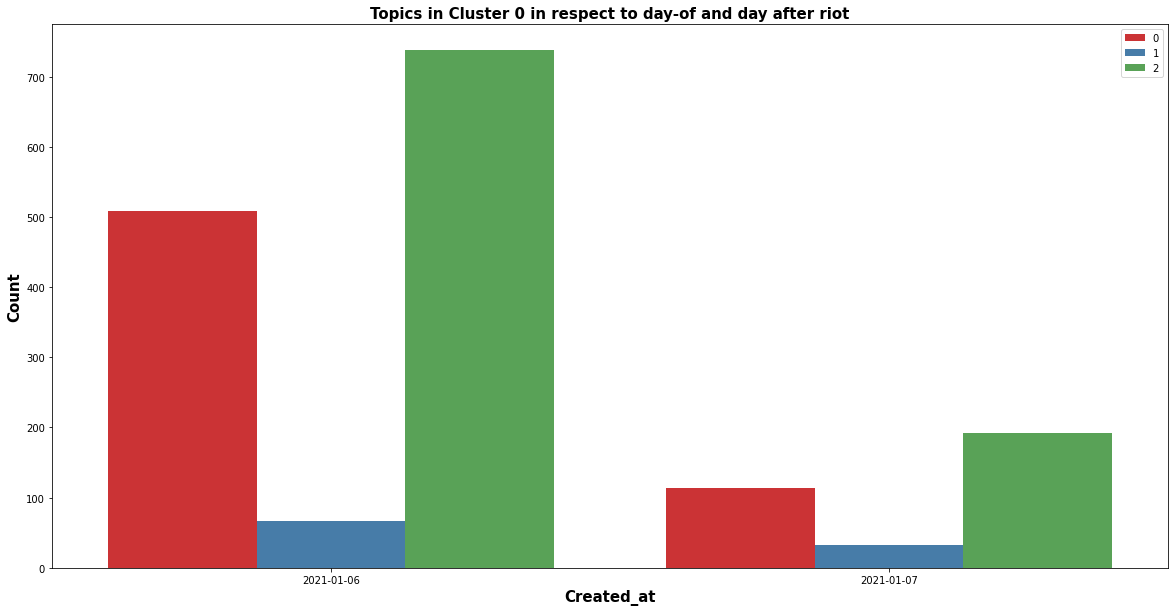

In [121]:
plt.figure(figsize=(20,10))
sns.countplot(temp['created_at'], hue=temp['Dominant_Topic'], palette = 'Set1')
plt.legend(loc='upper right')
plt.ylabel('Count', fontsize=15, fontweight='bold')
plt.xlabel('Created_at', fontsize=15, fontweight='bold')
plt.title('Topics in Cluster 0 in respect to day-of and day after riot', fontsize=15, fontweight='bold')
plt.show()

In [122]:
temp2 = lda_df[lda_df['survivability_x'] == 554]

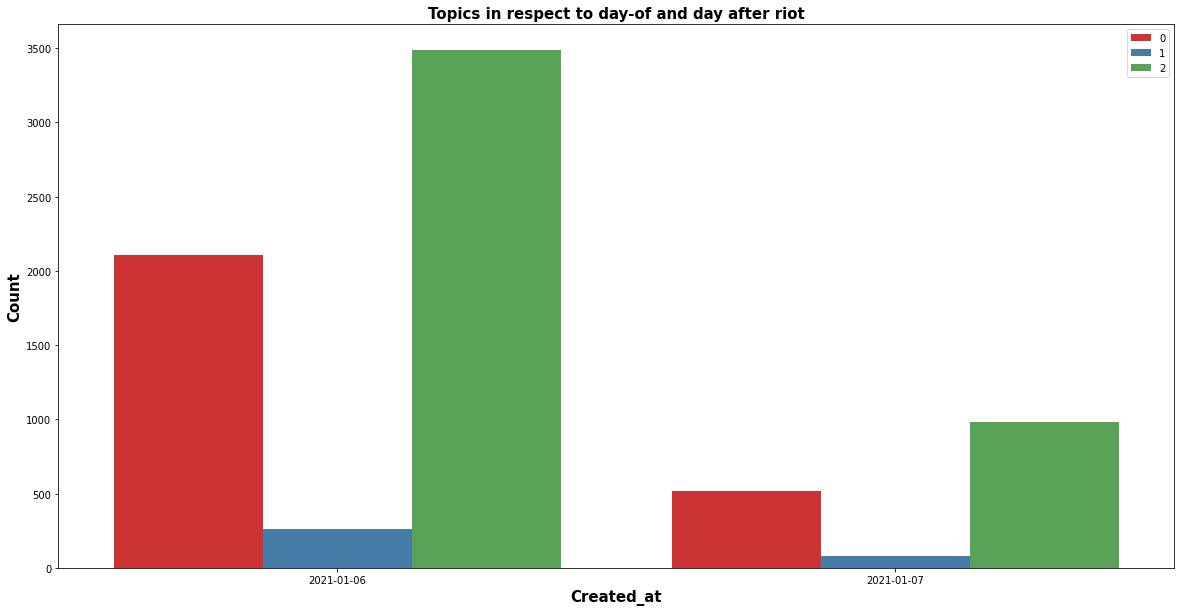

In [123]:
plt.figure(figsize=(20,10))
sns.countplot(temp2['created_at'], hue=temp2['Dominant_Topic'], palette = 'Set1')
plt.legend(loc='upper right')
plt.ylabel('Count', fontsize=15, fontweight='bold')
plt.xlabel('Created_at', fontsize=15, fontweight='bold')
plt.title('Topics in respect to day-of and day after riot', fontsize=15, fontweight='bold')
plt.show()